In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet

In [2]:
def test_model(model, X, y, cv=5,verbose=False):
    test_error = []
    for i, (train_index, test_index) in enumerate(KFold(n_splits=cv).split(X)):
        model.fit(X[train_index], y[train_index])
        y_pred = model.predict(X[test_index])
        test_error.append(root_mean_squared_error(y[test_index], y_pred))
        if verbose:
            print(f"Fold {i+1}: {root_mean_squared_error(y[test_index], y_pred)}")
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean: {np.mean(test_error)}")
    print(f"Std: {np.std(test_error)}")
    return test_error
def centerData(data):
    mu = np.mean(data,axis=0)
    data = data - mu
    return data, mu
def normalize(X):
    d = np.linalg.norm(X,axis=0,ord=2)
    d[d==0]=1
    X_pre = X / d
    return X_pre,d

In [3]:
raw_data = pd.read_csv('case1Data.txt')
raw_data = raw_data.replace([' NaN','NaN',' NaN ','NaN '], np.nan)
y = raw_data['y']
X_num = raw_data.loc[:, ' x_ 1':' x_95'].astype(float) 
X_cat = raw_data.loc[:, ' C_ 1':' C_ 5']
X_cat_np = X_cat.to_numpy()

In [4]:
X_cat_features = []
for i in range(X_cat.shape[1]):
    unique_values = X_cat.iloc[:, i].unique()
    unique_values = unique_values[~pd.isna(unique_values)]  # Filter out nan values
    unique_values = np.append(unique_values, np.nan)
    X_cat_features.append(unique_values)
encoder = OneHotEncoder(categories=X_cat_features)
X_cat_encoded = encoder.fit_transform(X_cat_np)

In [5]:
mapping = {'G': 1, 'H': 2, 'I': 3, 'J': 4, 'K': 5, 'Na': 6}
X_cat_label = (X_cat.fillna('Na')).applymap(lambda x: mapping.get(str(x).strip(), x))

In [6]:
imp = SimpleImputer(strategy='mean')
X = pd.concat([X_num, X_cat_label], axis=1)
X_imp = imp.fit_transform(X)
X_imp_standardized = normalize(X_imp)[0]

## Test models: Right branch

In [10]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=1000, num=10)]
learning_rate = np.linspace(0.01, 1, 50)
loss = ['linear']
estimator = [LassoCV(max_iter=50000,tol=0.1), RidgeCV()]

param_grid = {'estimator' : estimator,
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'loss': loss}

ada = AdaBoostRegressor()
ada_random = RandomizedSearchCV(estimator=ada, param_distributions=param_grid, n_iter=50, cv=3, verbose=2, n_jobs=-1)
ada_random.fit(X_imp_standardized, y)
ada_random.best_params_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 780,
 'loss': 'linear',
 'learning_rate': 0.07061224489795918,
 'estimator': LassoCV(max_iter=50000, tol=0.1)}

In [18]:
# Elastic net
RMSE_elastic = test_model(ElasticNet(alpha=0.3359818286283781, l1_ratio=1.0), X_imp_standardized, y, cv=5, verbose=False)
# Lasso
RMSE_lasso = test_model(Lasso(alpha=0.14), X_imp_standardized, y, cv=5, verbose=False)
# Random forest
RMSE_rf = test_model(RandomForestRegressor(n_estimators=600, min_samples_split=5, min_samples_leaf=4, max_depth=80, bootstrap=True), X_imp_standardized, y, cv=5, verbose=False)
# AdaBoost
RMSE_ada = test_model(AdaBoostRegressor(n_estimators=230, loss='linear', learning_rate=0.373673469387755, estimator=LassoCV(max_iter=50000, tol=0.001)), X_imp_standardized, y, cv=5, verbose=False)
# HistGradientBoosting
RMSE_gradient = test_model(HistGradientBoostingRegressor(validation_fraction=0.2, random_state=0, min_samples_leaf=4, max_leaf_nodes=None, max_iter=100, max_depth=20, learning_rate=0.01, early_stopping=True), X_imp_standardized, y, cv=5, verbose=False)

Model: ElasticNet
Mean: 33.06005422006701
Std: 9.346825664936446
Model: Lasso
Mean: 28.21841102874767
Std: 6.6131964893711945
Model: RandomForestRegressor
Mean: 39.74354071950005
Std: 9.523833395913321
Model: AdaBoostRegressor
Mean: 26.163378209506703
Std: 4.223571151433611
Model: HistGradientBoostingRegressor
Mean: 46.73235969430247
Std: 8.091318808784829


## Test models: Left Branch
### Model Encoding:

In [81]:
# AdaBoost OneHot
RMSE_ada_OneHot = test_model(AdaBoostRegressor(n_estimators=2000, loss='linear', learning_rate=0.5757142857142857, estimator=LassoCV(max_iter=5000)), X_cat_encoded, y, cv=5, verbose=False)
# AdaBoost Label
RMSE_ada_Label = test_model(AdaBoostRegressor(n_estimators=2000, loss='linear', learning_rate=0.676734693877551, estimator=LassoCV(max_iter=5000)), X_cat_label.to_numpy(), y, cv=5, verbose=False)
# Random forest OneHot
RMSE_rf_OneHot = test_model(RandomForestRegressor(n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=60, bootstrap=True), X_cat_encoded, y, cv=5, verbose=False)
RMSE_rf_Label = test_model(RandomForestRegressor(n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=60, bootstrap=True), X_cat_label.to_numpy(), y, cv=5, verbose=False)
# Lasso OneHot
RMSE_lasso_OneHot = test_model(Lasso(alpha=4.842528290199999), X_cat_encoded, y, cv=5, verbose=False)
# Lasso Label
RMSE_lasso_Label = test_model(Lasso(alpha=9.6610262932), X_cat_label.to_numpy(), y, cv=5, verbose=False)
# Ridge OneHot
RMSE_ridge_OneHot = test_model(Ridge(alpha=170.26846846846846), X_cat_encoded, y, cv=5, verbose=False)
# Ridge Label
RMSE_ridge_label = test_model(Ridge(alpha=10000), X_cat_label.to_numpy(), y, cv=5, verbose=False)

Model: AdaBoostRegressor
Mean: 59.435631780904444
Std: 5.258857081677979
Model: AdaBoostRegressor
Mean: 56.093416617688625
Std: 3.6476401124448574
Model: RandomForestRegressor
Mean: 57.8702772804999
Std: 7.311605823508181
Model: RandomForestRegressor
Mean: 57.27495010766796
Std: 6.919773969832535
Model: Lasso
Mean: 55.337393065050364
Std: 5.485788484586642
Model: Lasso
Mean: 55.25918395265819
Std: 5.071644891941095
Model: Ridge
Mean: 54.95671896993749
Std: 5.2926474975676925
Model: Ridge
Mean: 55.01036751814229
Std: 5.2807394832245365


### Model:

In [7]:
r = Ridge(alpha=170.26846846846846)
r.fit(X_cat_encoded, y)
y_pred_cat = r.predict(X_cat_encoded)

In [8]:
X_left = X_num
X_left['y_cat'] = y_pred_cat
X_left_imp = imp.fit_transform(X_left)
X_left_imp_standardized = normalize(X_left_imp)[0]
X = X_left

In [21]:
alphas = np.linspace(0.9, 0.001, 100)  # Range of alphas to test
CV = 5  # Number of cross-validation folds
kf = KFold(n_splits=CV)

# Prepare arrays to store results
Err_tr = np.zeros((CV, len(alphas)))
Err_tst = np.zeros((CV, len(alphas)))

# Start cross-validation
for i, (train_index, test_index) in enumerate(kf.split(X,y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Data preprocessing (impute, center, normalize)
    imp = SimpleImputer(strategy='mean')
    X_train_imputed = imp.fit_transform(X_train)
    X_test_imputed = imp.transform(X_test)

    # Assuming centerData and normalize are functions you've defined previously
    y_train, y_mean = centerData(y_train)  # Center training response
    y_test = y_test - y_mean                # Center test response using the same mean

    X_train_imputed, x_mu = centerData(X_train_imputed)  # Center training data
    X_test_imputed = X_test_imputed - x_mu               # Center test data using the same mean

    X_train_imputed, x_scale = normalize(X_train_imputed)  # Normalize training data
    X_test_imputed = X_test_imputed / x_scale              # Normalize test data using the same scale

    # Iterate through alphas
    for j, alpha in enumerate(alphas):
        # Fit Lasso model with current alpha
        reg = Lasso(alpha=alpha,max_iter=10000)
        reg.fit(X_train_imputed, y_train)
        
        # Predict and find error for both train and test datasets
        YhatTr = reg.predict(X_train_imputed)  # Use the model's predict method
        YhatTest = reg.predict(X_test_imputed)  # Use the model's predict method
        
        # Store the training and test errors (MSE)
        Err_tr[i, j] = root_mean_squared_error(y_train, YhatTr)  # Training error
        Err_tst[i, j] = root_mean_squared_error(y_test, YhatTest) # Test error

# Calculate the average RMSE over all CV folds for each alpha
mean_err_tr = np.mean(Err_tr, axis=0)  # Average training RMSE for each alpha
mean_err_tst = np.mean(Err_tst, axis=0)  # Average test RMSE for each alpha
std_err_tst = np.std(Err_tst, axis=0) / np.sqrt(CV)  # Standard error of test RMSE for each alpha

# Find the index of the smallest average test RMSE
optimal_alpha_index = np.argmin(mean_err_tst)
optimal_alpha = alphas[optimal_alpha_index]
optimal_err_tst = mean_err_tst[optimal_alpha_index]
optimal_err_ste = std_err_tst[optimal_alpha_index]

# Print the details of the optimal model
print("Optimal alpha:", optimal_alpha)
print("Associated mean test RMSE:", optimal_err_tst)
print("Standard error of the mean test RMSE:", optimal_err_ste)
print("Associated mean training RMSE for optimal alpha:", mean_err_tr[optimal_alpha_index])


Optimal alpha: 0.13721212121212112
Associated mean test RMSE: 24.57477971581286
Standard error of the mean test RMSE: 2.8740824808931182
Associated mean training RMSE for optimal alpha: 14.611151617695999


In [22]:
# Lasso Left
RMSE_Left_lasso = test_model(Lasso(alpha=0.13721212121212112), X_left_imp_standardized, y, cv=5, verbose=False)
# Random forest Left
RMSE_left_rf = test_model(RandomForestRegressor(n_estimators=800, min_samples_split=2, min_samples_leaf=1, max_depth=110, bootstrap=True), X_left_imp_standardized, y, cv=5, verbose=False)
# adaBoost Left
RMSE_ada_Lasso = test_model(AdaBoostRegressor(n_estimators=300, loss='linear', learning_rate=0.30204081632653063, estimator=LassoCV(max_iter=5000,tol=0.01)), X_left_imp_standardized, y, cv=5, verbose=False)

Model: Lasso
Mean: 28.14889796451639
Std: 6.5607369904197075
Model: RandomForestRegressor
Mean: 39.91741669536812
Std: 9.544907225048242
Model: AdaBoostRegressor
Mean: 25.71391510245079
Std: 4.874313639426428


## Final model

In [9]:
final = AdaBoostRegressor(n_estimators=300, loss='linear', learning_rate=0.30204081632653063, estimator=LassoCV(max_iter=5000,tol=0.01))
final.fit(X_left_imp_standardized, y)
cat_ = Ridge(alpha=170.26846846846846)
cat_.fit(X_cat_encoded, y)

Ridge(alpha=170.26846846846846)

In [36]:
colmn_names = X_left.columns
raw_data = pd.read_csv('case1Data_Xnew.txt')
raw_data = raw_data.replace('NaN', np.nan)
raw_data = raw_data.replace(' NaN', np.nan)
raw_data = raw_data.replace(' NaN ', np.nan)
raw_data = raw_data.replace('NaN ', np.nan)

X_num = raw_data.loc[:, 'x_ 1':' x_95'].astype(float) 
X_cat = raw_data.loc[:, ' C_ 1':' C_ 5'] 

y_pred = cat_.predict(encoder.fit_transform(X_cat.to_numpy()))

X_num['y_cat'] = y_pred
X_imputed = X_num.fillna(X_num.mean())
X_imputed.columns = colmn_names
X_imputed_standardized = normalize(X_imputed)[0]
X_imputed_standardized = X_imputed_standardized.to_numpy()

y_pred_final = final.predict(X_imputed_standardized)
y_final = list(y_pred_final)
np.savetxt('y_pred.txt', y_final, delimiter=',',fmt='%f')

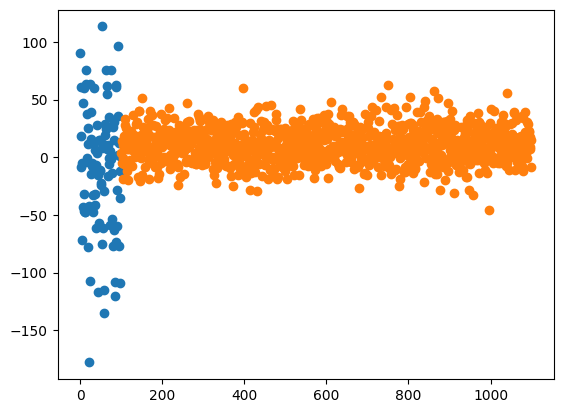

In [30]:
plt.scatter(range(len(y)),y)
plt.scatter(range(len(y),len(y_pred_final)+len(y)),y_pred_final)